In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import iris
import iris.quickplot as qplt
import iris.plot as iplt
from iris.coord_categorisation import add_year
from iris.coord_categorisation import add_month_number
from iris.coord_categorisation import add_day_of_month
import pandas as pd
import datetime
%matplotlib

Using matplotlib backend: Qt5Agg


In [4]:
precip_cubes = iris.load_cube('/project/MJO_GCSS/hadgem3/data/obs/SEAPy_data/obs/obs_PRECIP.pp.nc')
#precip_cubes = precip_cubes.intersection(longitude=(95, 130), latitude=(-10,25))

In [5]:
def prepare_calendar(cube):
    # Setting up the dates on data
    if not cube.coords('year'):
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    if not cube.coords('month_number'):
        iris.coord_categorisation.add_month_number(cube, 'time', name='month_number')
    if not cube.coords('day_of_month'):
        iris.coord_categorisation.add_day_of_month(cube, 'time', name='day_of_month')
    return cube

In [6]:
def return_indices_of_a(a, b):
  b_set = set(b)
  return [i for i, v in enumerate(a) if v in b_set]

In [7]:
cstype=['NDJF', 'CS', 'CES', 'MS', 'ES']
    
precip_cubes = prepare_calendar(precip_cubes)

In [8]:
precip_cubes

Daily (0Z-21Z) Rainfall Total (mm),time,latitude,longitude
Shape,6330,61,360
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
day_of_month,x,-,-
month_number,x,-,-
year,x,-,-
Attributes,,,


In [9]:
def mjo_phase_indices(cube, season='NDJF', phases=[1]):
    mjo_dates_file = '/project/MJO_GCSS/hadgem3/data/MJOPy_output/obs/RMMs_obs.txt'
    df = pd.read_csv(mjo_dates_file, sep=' ', names=['year', 'month', 'day', 'rmm1', 'rmm2', 'phase', 'amp'])
    df['date'] = [datetime.datetime(y,m,d) for y, m, d in zip(df.year, df.month, df.day)]
    if season == 'NDJF':
        ndjf_df = df.loc[(df['month'].isin([11,12,1,2]))]
        phase_df = ndjf_df.loc[(ndjf_df['amp']>=1)&(ndjf_df['phase'].isin(phases))]
        # get dates of the cube
        times = cube.coord('time')
        dtimes = times.units.num2date(times.points)
        dft_cubes = pd.DataFrame(pd.to_datetime(dtimes, format='%Y%m%d'))
        dft_cubes.columns = ['dates']
        
        # get indices of cube that matches the CS dates
        season_indices = return_indices_of_a(dft_cubes['dates'], ndjf_df['date'])
        phase_indices = return_indices_of_a(dft_cubes['dates'], phase_df['date'])
        
        return season_indices, phase_indices

In [10]:
season_indices, phase_indices = mjo_phase_indices(precip_cubes, phases=[4,5])
#dft_cubes['dates'][inds]
seas =  precip_cubes[season_indices].collapsed('time', iris.analysis.MEAN)
p1 = precip_cubes[phase_indices].collapsed('time', iris.analysis.MEAN)

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_month'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month_number'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/d

In [11]:
qplt.contourf(p1-seas, cmap='RdBu', levels=np.linspace(-12,12,11))
plt.gca().coastlines()

In [12]:
# get dates of the cube
times = precip_cubes.coord('time')
dtimes = times.units.num2date(times.points)
dft_cubes = pd.DataFrame(pd.to_datetime(dtimes, format='%Y%m%d'))
dft_cubes.columns = ['dates']
# get indices of cube that matches the CS dates
#indices = return_indices_of_a(dft_cubes['dates'], phase1_df['date'])
#print(len(indices))
# compute percentiles

In [13]:
def compute_mjo_percentiles(cube, indices, runid = 'obs', phase = 'NDJF', percent=[95]):
    # compute percentiles
    percentiles = cube[indices].collapsed('time', iris.analysis.PERCENTILE, percent=percent)
    return percentiles

In [14]:
def compute_cs_percentiles(cube, runid = 'obs', cstype = 'NDJF', percent=[95]):
    # read the CS/seasonal dates
    cs_dates_file = os.path.join('/project/MJO_GCSS/hadgem3/data/SEAPy_output/',runid, "%s_%s_dates.txt" % (runid, cstype))
    print(cs_dates_file)
    df = pd.read_csv(cs_dates_file, header=None)
    df.columns = ['dates']
    df['datetime'] = pd.to_datetime(df['dates'], format='%Y%m%d')
    dft_cst = pd.DataFrame(df['datetime'])
    
    # get dates of the cube
    times = cube.coord('time')
    dtimes = times.units.num2date(times.points)
    dft_cubes = pd.DataFrame(pd.to_datetime(dtimes, format='%Y%m%d'))
    dft_cubes.columns = ['dates']
    
    # get indices of cube that matches the CS dates
    indices = return_indices_of_a(dft_cubes['dates'], dft_cst['datetime'])
    print(len(ind))
    # compute percentiles
    percentiles = cube[ndjf_indices].collapsed('time', iris.analysis.PERCENTILE, percent=percent)
    return percentiles

In [15]:
ndjf_perc = compute_cs_percentiles(precip_cubes, cstype='NDJF', percent=[95])

/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_NDJF_dates.txt


NameError: name 'ind' is not defined

In [208]:
ndjf_mjo_perc = compute_mjo_percentiles(precip_cubes, indices, phase='NDJF', percent=[95])

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_month'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month_number'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


In [209]:
qplt.contourf(ndjf_mjo_perc)

In [159]:
cs_perc = compute_percentiles(precip_cubes, cstype='CS', percent=[95])
ces_perc = compute_percentiles(precip_cubes, cstype='CES', percent=[95])

/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_CS_dates.txt
600


/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_month'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month_number'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


/project/MJO_GCSS/hadgem3/data/SEAPy_output/obs/obs_CES_dates.txt
754


/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_month'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month_number'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


In [16]:
plt.figure(1)
qplt.contourf(ndjf_perc, levels=np.arange(10, 80, 10), cmap='GnBu', extend='max')
plt.gca().coastlines()
plt.title('Obs NDJF 95th percentile')

plt.figure(2)
qplt.contourf(cs_perc, levels=np.arange(10, 80, 10), cmap='GnBu', extend='max')
plt.gca().coastlines()
plt.title('Obs CS 95th percentile')


plt.figure(3)
qplt.contourf(ces_perc, levels=np.arange(10, 80, 10), cmap='GnBu', extend='max')
plt.gca().coastlines()
plt.title('Obs CES 95th percentile')


NameError: name 'ndjf_perc' is not defined

In [162]:
plt.figure(4)
qplt.contourf(100*cs_perc/ndjf_perc, levels=np.arange(-200, 200, 20), cmap="RdBu_r", extend='both')
plt.gca().coastlines()
plt.title('Obs % CS change 95th percentile precip')

Text(0.5, 1.0, 'Obs % CS change 95th percentile precip')

In [163]:
plt.figure(5)
qplt.contourf(100*ces_perc/ndjf_perc, levels=np.arange(-200, 200, 20), cmap="RdBu_r", extend='both')
plt.gca().coastlines()
plt.title('Obs % CES change 95th percentile precip')

Text(0.5, 1.0, 'Obs % CES change 95th percentile precip')

/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'day_of_month'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'month_number'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/environments/default/2020_10_12/lib/python3.6/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'year'.
  warnings.warn(msg.format(self.name()))


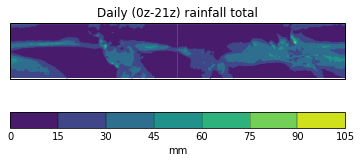

In [106]:
rmmfile='/project/MJO_GCSS/hadgem3/data/MJOPy_output/u-bw062/RMMs_u-bw062.txt'
df = pd.read_csv(rmmfile, sep=' ', names=['year', 'month', 'day', 'rmm1', 'rmm2', 'phase', 'amp'])

In [115]:
#df['date'] = [datetime.datetime(y, m, d) for y, m, d in zip(df.year, df.month, df.day)]
#str(date.year), str('%02d' % date.month), str('%02d' % date.day)
date_strings = ['%s%s%s' %(str(y), str('%02d' % m), str('%02d' % d)) for y, m, d in zip(df.year, df.month, df.day)]

In [116]:
df['date'] = pd.DataFrame(pd.to_datetime(dates_trings, format='%Y%m%d', errors='coerce'))

In [118]:
df

,year,month,day,rmm1,rmm2,phase,amp,date
0,1988,9,1,-999.0,-999.0,-999,-999.0,1988-09-01
1,1988,9,2,-999.0,-999.0,-999,-999.0,1988-09-02
2,1988,9,3,-999.0,-999.0,-999,-999.0,1988-09-03
3,1988,9,4,-999.0,-999.0,-999,-999.0,1988-09-04
4,1988,9,5,-999.0,-999.0,-999,-999.0,1988-09-05
...,...,...,...,...,...,...,...,...
7285,2008,11,26,-999.0,-999.0,-999,-999.0,2008-11-26
7286,2008,11,27,-999.0,-999.0,-999,-999.0,2008-11-27
7287,2008,11,28,-999.0,-999.0,-999,-999.0,2008-11-28
7288,2008,11,29,-999.0,-999.0,-999,-999.0,2008-11-29


In [119]:
cube = iris.load_cube('/scratch/hadpx/hadgem3/data/SEAPy/u-bw062/u-bw062_PRECIP.pp.nc')

In [121]:
# get dates of the cube
times = cube.coord('time')
dtimes = times.units.num2date(times.points)

In [133]:
dtf = pd.DataFrame(dtimes, columns=['date'])
#dft_cubes = pd.to_datetime(dtimes, format='%Y-%m-%d')
#dft_cubes.columns = ['dates']

In [153]:
dtc_str = [str(dd).split()[0] for dd in dtf['date']]

In [161]:
dtf['dates'] = pd.DataFrame(pd.to_datetime(dtc_str, format='%Y-%m-%d', errors='coerce'))

In [162]:
dtf

,date,dates
0,1988-09-01 12:00:00,1988-09-01
1,1988-09-02 12:00:00,1988-09-02
2,1988-09-03 12:00:00,1988-09-03
3,1988-09-04 12:00:00,1988-09-04
4,1988-09-05 12:00:00,1988-09-05
...,...,...
7285,2008-11-26 12:00:00,2008-11-26
7286,2008-11-27 12:00:00,2008-11-27
7287,2008-11-28 12:00:00,2008-11-28
7288,2008-11-29 12:00:00,2008-11-29


In [2]:
data_file = '/project/MJO_GCSS/hadgem3/data/obs/ERA5_tropical_U850_2000_2020_dailymean.nc'

In [4]:
data_file.split('.')[0]+'_filt.nc'

'/project/MJO_GCSS/hadgem3/data/obs/ERA5_tropical_U850_2000_2020_dailymean_filt.nc'